# Diabetes or not: A Comprehensive Analysis of Diabetical Symptoms in Pima Indians Diabetes Database #

### by Brian Adhitya, Wyatt Howell, Brian Ko, Nishanth Selvakumar

### Introduction

Diabetes is a common and chronic condition characterized by high blood sugar levels. It occurs when the body can't produce enough insulin or can't use it effectively. There are different types of diabetes, including Type 1, where the immune system attacks insulin-producing cells, and Type 2, usually linked to insulin resistance. Diabetes is a major global health concern, leading to complications like heart diseases, kidney issues, vision problems, and nerve damage. Lifestyle factors and genetics contribute to its development. Management involves medication, lifestyle changes, and regular monitoring. Due to its widespread impact, diabetes is a focus of ongoing research and public health efforts. In recent years in Canada, almost 1 in 10 adults from age 20 - 79 are diabetic, and of those adults aged 60 - 79 diabetes occurs in 1 in 5 (Statcan). 

This dataset provides insight into diabetic diagnosis based on certain health factors for women over the age of 21 of Pima Indian heritage. The Pima is a Native American group situated in southern Arizona, USA. The health factors include the amount of pregnancies, glucose concentration (orally tested), blood pressure, skin thickness, BMI, diabetes pedigrees function, insulin level, and age. Understanding the health factors that are prevalent in diabetic patients is essential for developing treatment methods. Using these factors we will be able to notice trends, patterns, and relationships and use these to predict the diabetic outcome of an undiagnosed patient. This dataset will inform people of what health factors could possibly lead to diabetes at a later age, and what preventative measures could be taken. 

The question we are trying to answer is: **How will other health factors influence glucose concentration, and a patients diabetes diagnosis?**

### Loading libraries

In [1]:
# importing libraries
library(tidyverse)
library(repr)
library(janitor)
library(ggplot2)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ──────

### Preeliminary exploratory data analysis

**1. Loading and cleaning the Dataset**

In [2]:
# Cleaning names and specifying categorical variable
diabetes <- read_csv("data/diabetes.csv") |>
            clean_names() |>
            mutate(outcome = as_factor(outcome)) |>
            mutate(diabetes = fct_recode(outcome, "Yes" = "1", "No" = "0")) |>
            select(-outcome)

# Displaying the data
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,Yes
1,85,66,29,0,26.6,0.351,31,No
8,183,64,0,0,23.3,0.672,32,Yes
1,89,66,23,94,28.1,0.167,21,No
0,137,40,35,168,43.1,2.288,33,Yes
5,116,74,0,0,25.6,0.201,30,No


**2. Splitting into testing and training**

In [3]:
# splitting the diatabes data
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = diabetes)

# training data
diabetes_training <- training(diabetes_split)

# testing data
diabetes_testing <- testing(diabetes_split)

# the data to be used
head(diabetes_training)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,85,66,29,0,26.6,0.351,31,No
1,89,66,23,94,28.1,0.167,21,No
5,116,74,0,0,25.6,0.201,30,No
10,115,0,0,0,35.3,0.134,29,No
4,110,92,0,0,37.6,0.191,30,No
1,103,30,38,83,43.3,0.183,33,No


**3. Cleaning and wrangling data**

In [4]:
# Summarizing the age data
diabetes_summary_age <- diabetes_training |>
                        group_by(diabetes) |>
                        summarize(min_age = min(age, na.rm = TRUE),
                                max_age = max(age, na.rm = TRUE),
                                mean_age = mean(age, na.rm = TRUE))

# Summarizing the glucose level data
diabetes_summary_glucose <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_glucose = min(glucose, na.rm = TRUE),
                                      max_glucose = max(glucose, na.rm = TRUE),
                                      mean_glucose = mean(glucose, na.rm = TRUE))

# Summarize the pregnancies data
diabetes_summary_pregnancies <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_pregnancies = min(pregnancies, na.rm = TRUE),
                                      max_pregnancies = max(pregnancies, na.rm = TRUE),
                                      mean_pregnancies = mean(pregnancies, na.rm = TRUE))

# joining all the summaries into a dataframe
diabetes_summary <- full_join(diabetes_summary_age, diabetes_summary_glucose, by = "diabetes") |>
                    full_join(diabetes_summary_pregnancies, by = "diabetes")

# displaying the data
head(diabetes_summary)

diabetes,min_age,max_age,mean_age,min_glucose,max_glucose,mean_glucose,min_pregnancies,max_pregnancies,mean_pregnancies
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,21,72,31.21867,0,194,108.5307,0,13,3.442667
Yes,21,70,37.06965,0,199,140.7711,0,17,4.885572


In [10]:
#Average glucose, blood pressure, bmi levels for number of pregnancies considered as a factor
diabetes_training_pregnant_stage <- diabetes_training |>
                            mutate(pregnancies = as_factor(pregnancies)) |>
                            group_by(pregnancies) |>
                            summarize(
                                average_glucose = mean(glucose),
                                average_bmi = mean(bmi),
                                average_blood_pressure = mean(blood_pressure))

diabetes_training_pregnant_stage

pregnancies,average_glucose,average_bmi,average_blood_pressure
<fct>,<dbl>,<dbl>,<dbl>
0,126.0139,34.85139,69.05556
1,112.3571,30.79184,66.93878
2,109.7831,30.76386,63.53012
3,118.1333,30.23167,67.80000
4,125.2292,32.12500,71.06250
5,118.1224,33.20408,76.79592
6,115.5676,30.87568,69.29730
7,135.8485,32.77273,68.33333
8,132.7000,31.71000,74.16667


**4. Visualizing some key points**

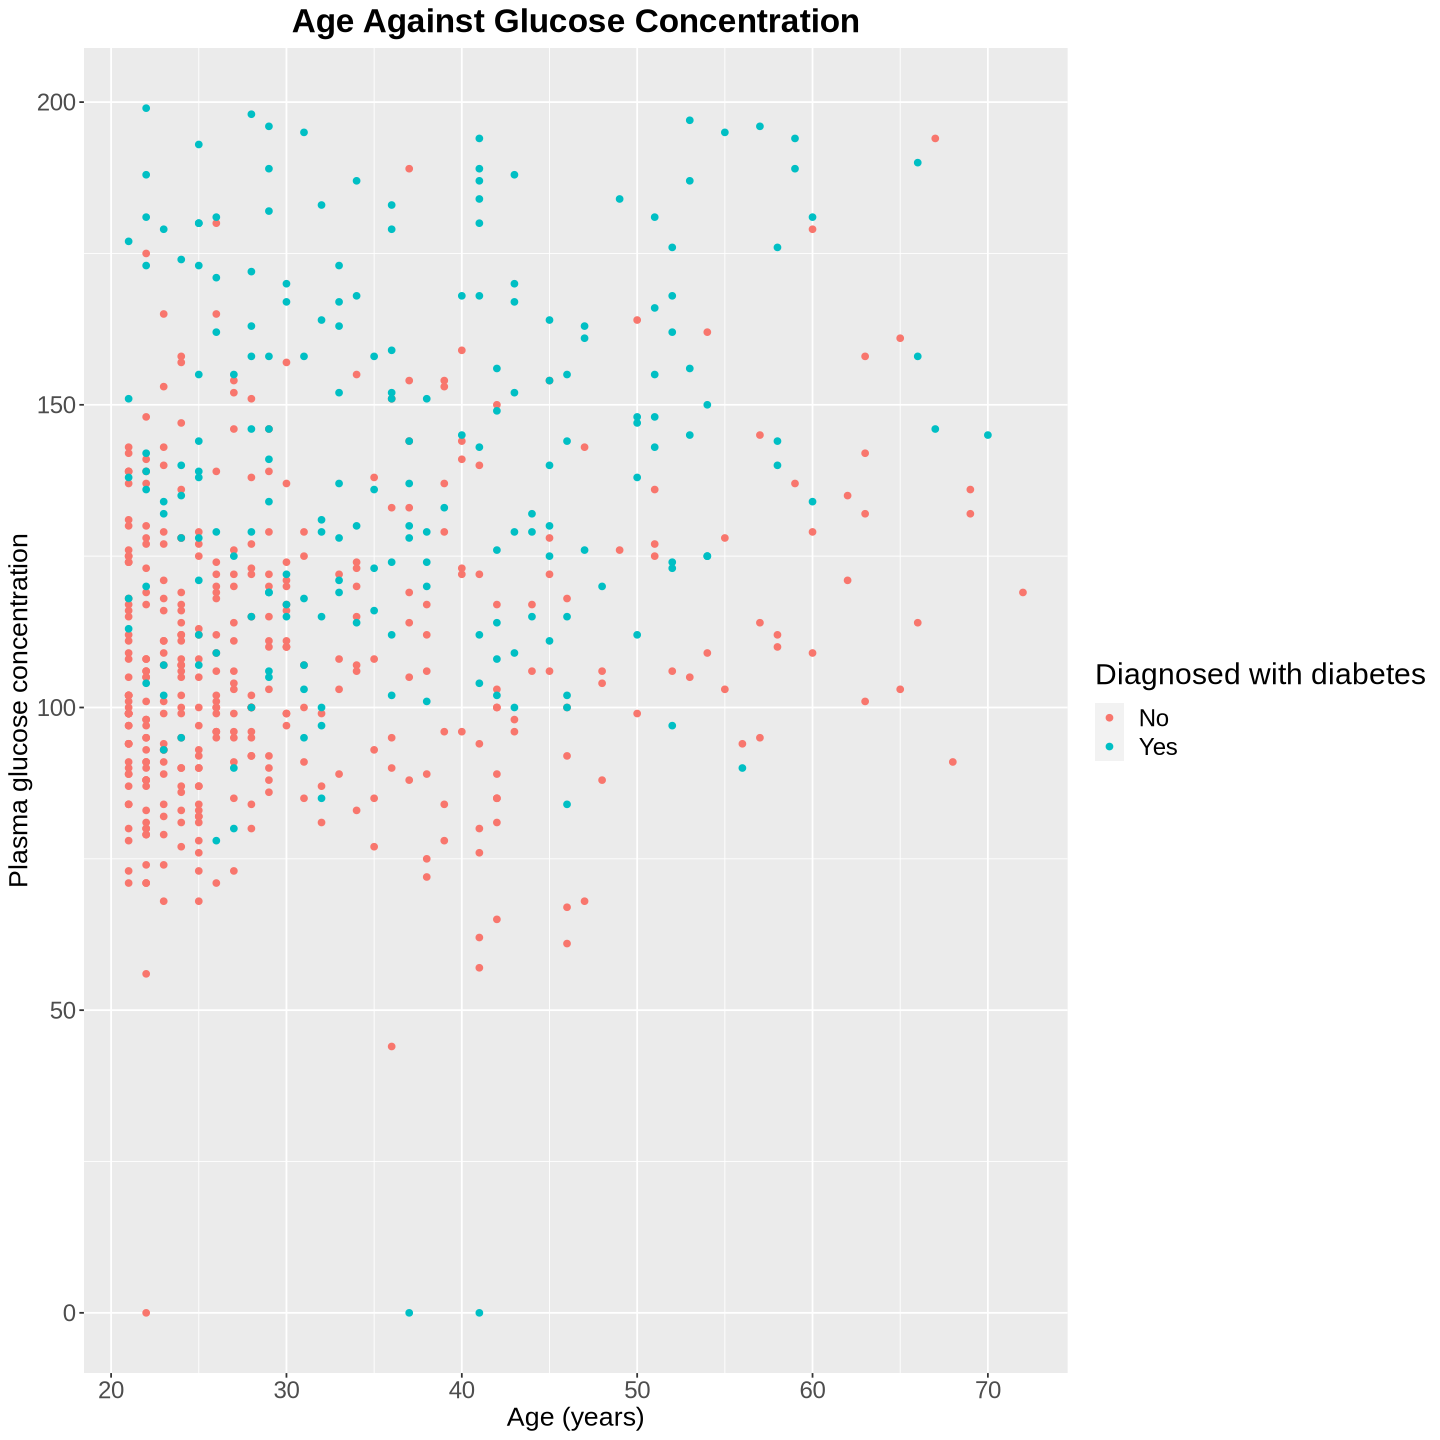

In [5]:
options(repr.plot.width = 12, repr.plot.height = 12)

diabetes_age_plot <- diabetes_training |>
                    ggplot(aes(x = age, y = glucose, color = diabetes)) +
                    geom_point(alpha = 1.5) +
                    xlab("Age (years)") +
                    ylab("Plasma glucose concentration") +
                    labs(color = "Diagnosed with diabetes") +
                    ggtitle("Age Against Glucose Concentration") +
                    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 16),
                          axis.title.y = element_text(size = 16))

diabetes_age_plot

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


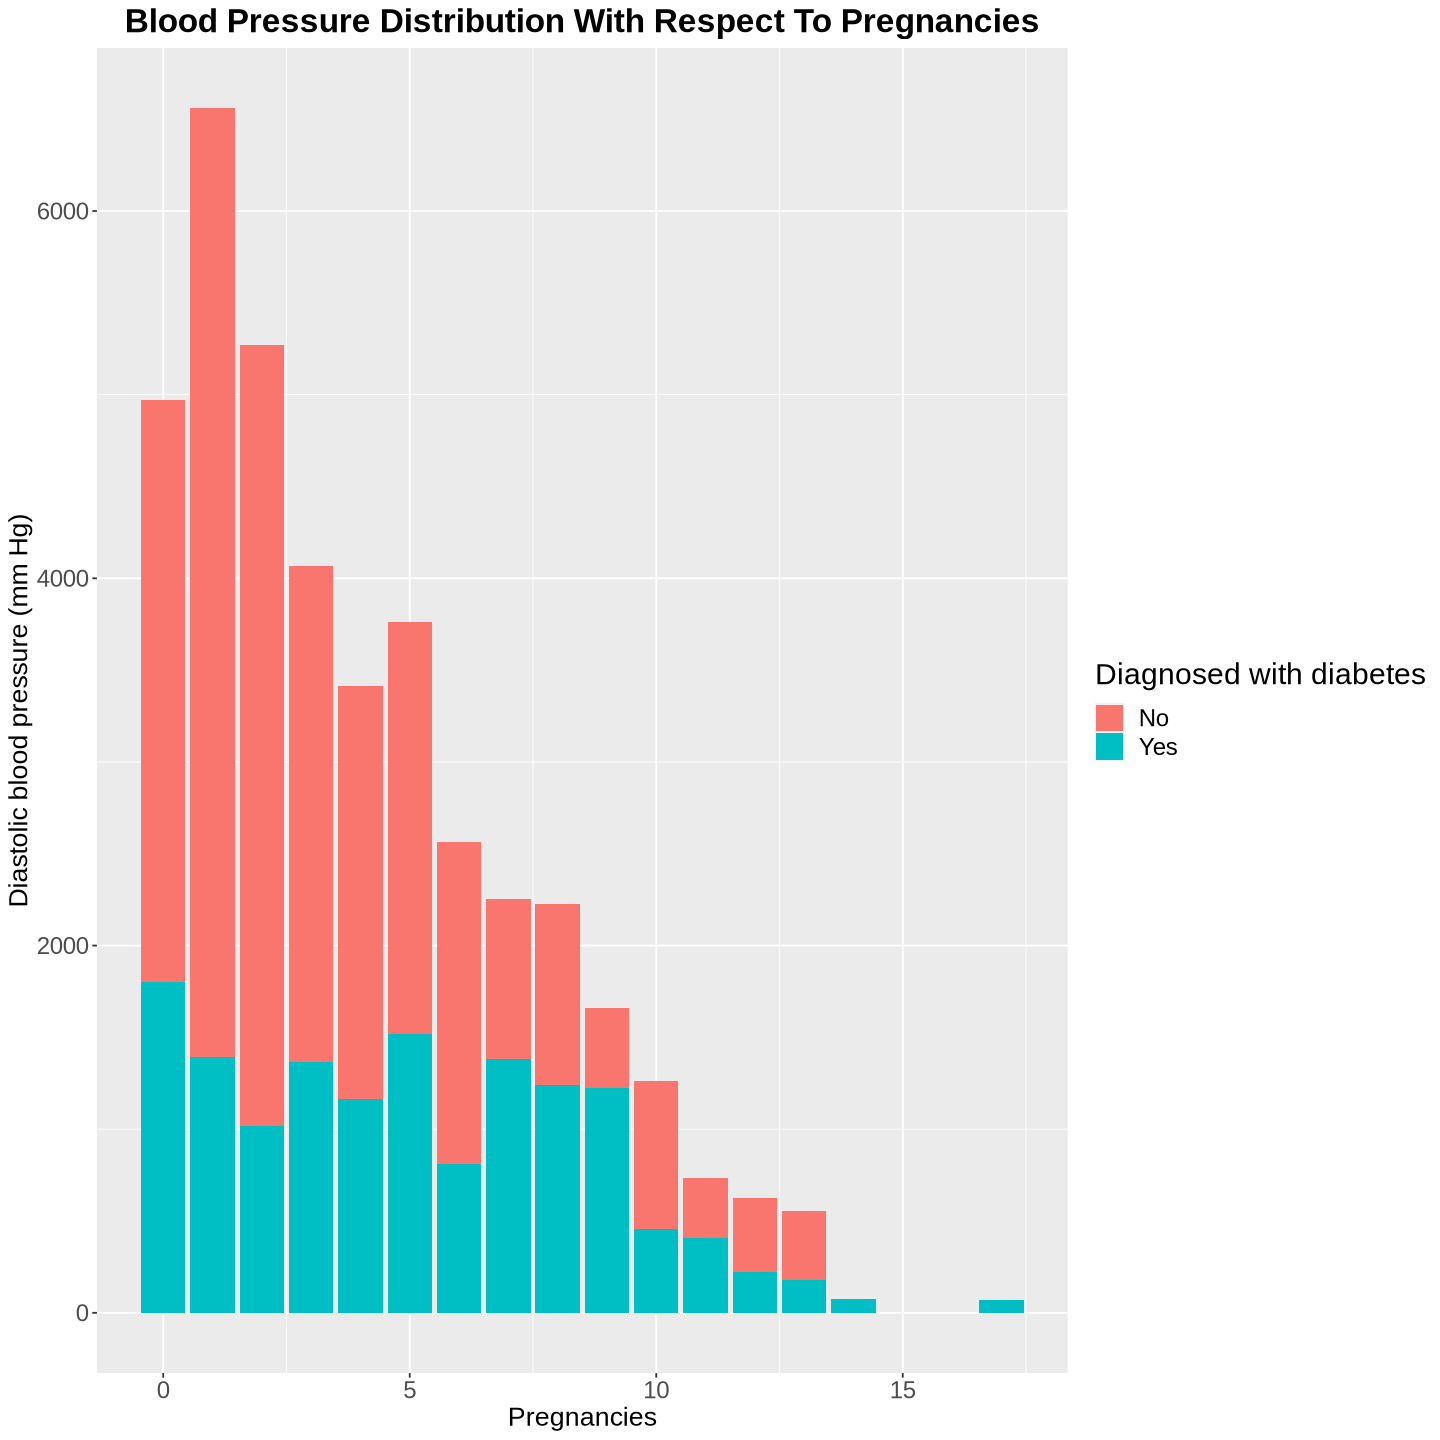

In [6]:
options(repr.plot.height = 12, repr.plot.width = 12)

diabetes_pressure_plot <- diabetes_training |> 
    ggplot(aes(x = pregnancies, y = blood_pressure, fill=diabetes)) + 
    geom_histogram(stat="identity") + 
    labs(x = "Pregnancies",
         y = "Diastolic blood pressure (mm Hg)",
         title = "Blood Pressure Distribution With Respect To Pregnancies",
         fill = "Diagnosed with diabetes") +
    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 16),
                          axis.title.y = element_text(size = 16))
diabetes_pressure_plot

`summarise()` has grouped output by 'age', 'diabetes'. You can override using
the `.groups` argument.


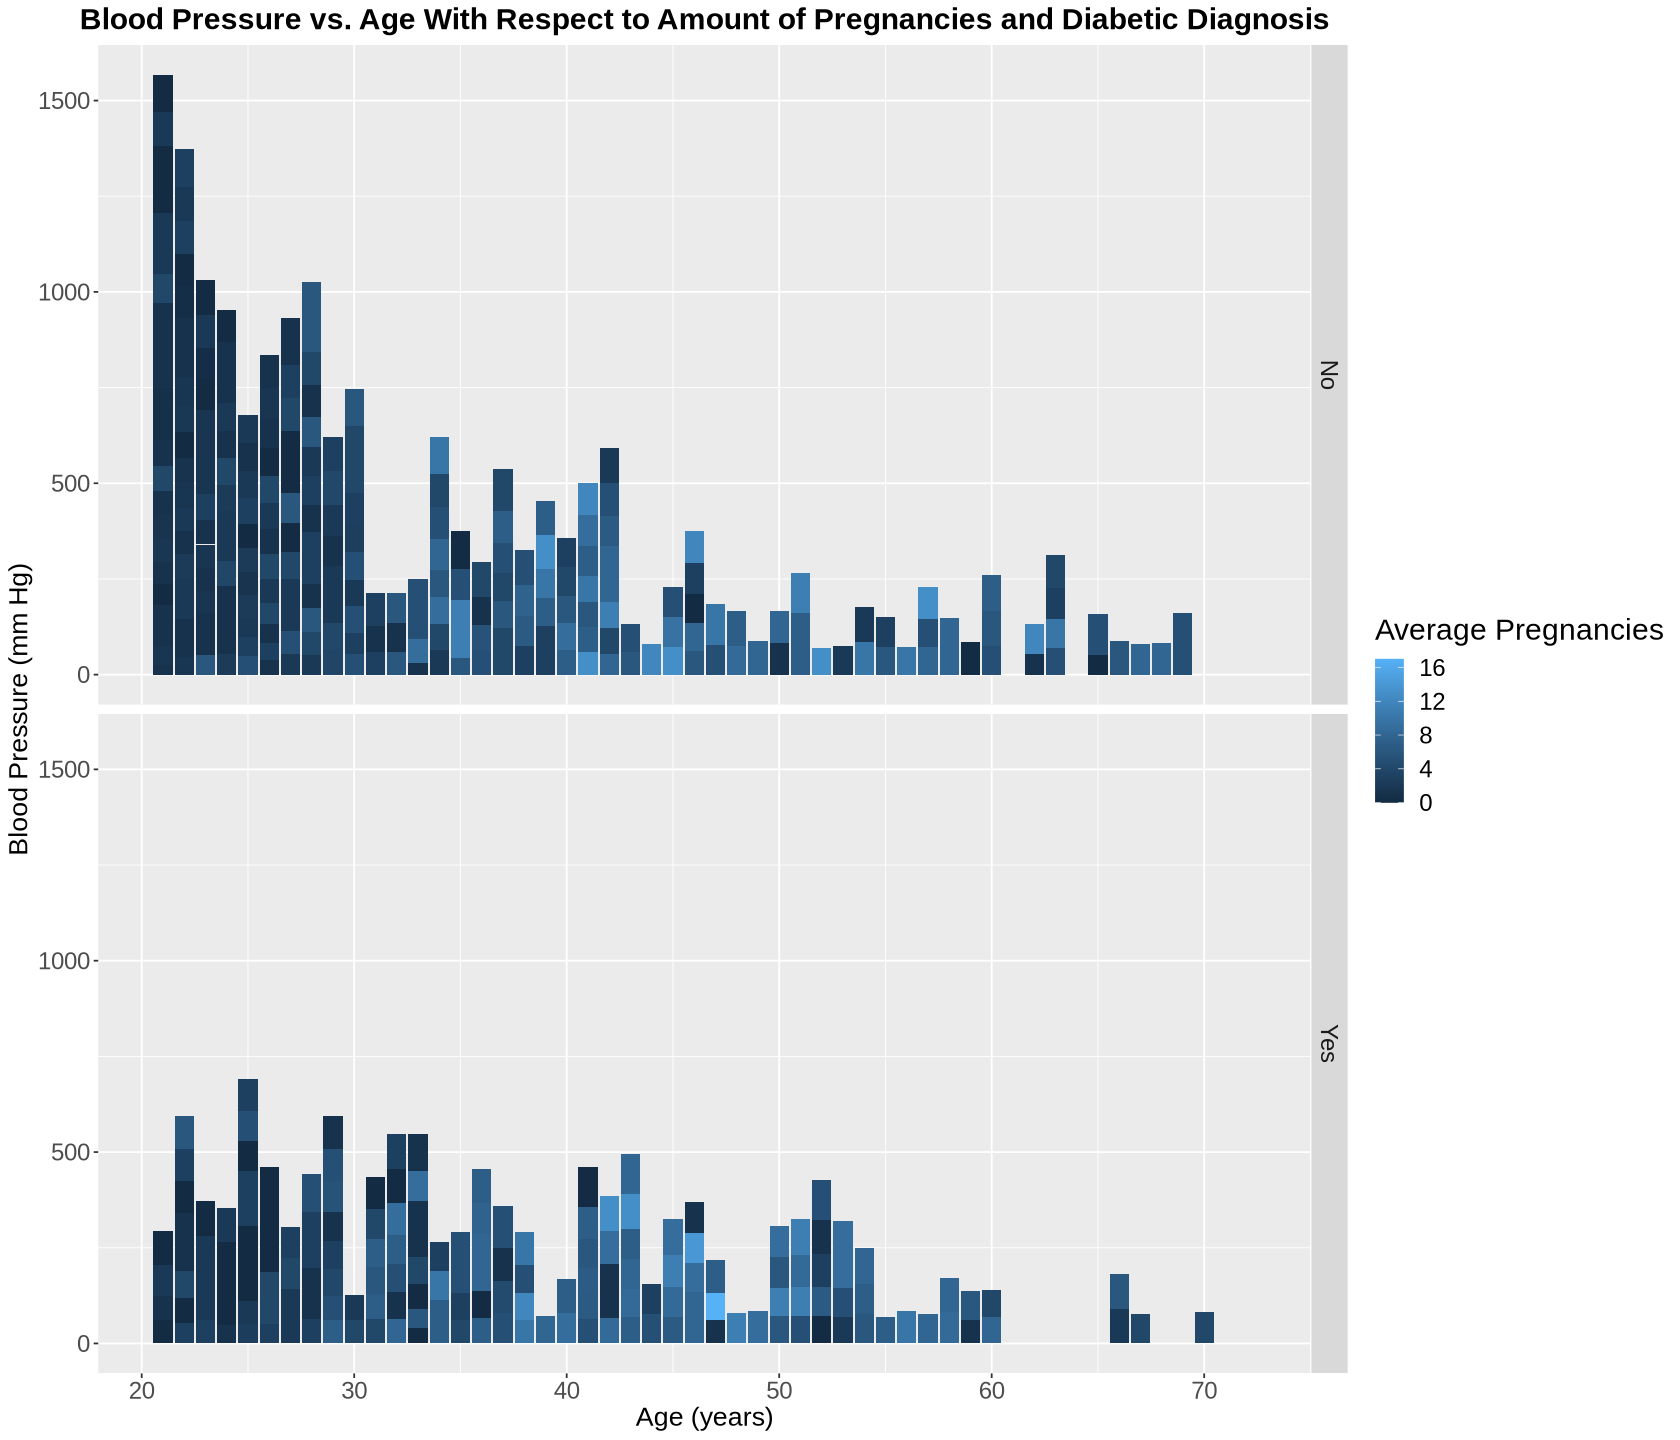

In [9]:
options(repr.plot.height = 12, repr.plot.width = 14)

average_pregnancies <- diabetes_training |> 
    group_by(age, diabetes, blood_pressure) |> 
    summarize(average_pregnancies = mean(pregnancies))

pregnant_diabetes <- average_pregnancies |> 
   ggplot(aes(x = age, y = blood_pressure, fill = average_pregnancies)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Age (years)", y = "Blood Pressure (mm Hg)", 
         title = "Blood Pressure vs. Age With Respect to Amount of Pregnancies and Diabetic Diagnosis", 
        fill = "Average Pregnancies") +
    facet_grid(rows = vars(diabetes)) + 
    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
                          axis.title.x = element_text(size = 16),
                          axis.title.y = element_text(size = 16))

pregnant_diabetes 


Analzying this plot we can determine that the amount of pregnancies as the patients age increases, which is as expected. As the patients reach the age range of 40 - 50 years old the women that do have diabetes generally have more children, as most of the histogram bars are lighter in colour. We can also determine that the women who have diabetes in this range tend to have a higher blood pressure, high blood pressure and pregnancies have a positive relationship, and is more common in patients with a positive diabetic diagnosis. 

### Methods

Based on the dataset source in **kaggle** (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database), we can classify the columns as below:

1. **pregnancies** - Number of times pregnant 
2. **glucose** - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. **blood pressure** - Diastolic blood pressure (mm Hg)
4. **skin thickness** - Triceps skin fold thickness (mm)
5. **insulin** - 2-Hour serum insulin (mu U/ml)
6. **bmi** - Body mass index (weight in kg/(height in m)^2)
7. **diabetic pedigree function** - Diabetes pedigree function
8. **age** - Age (years)
9. **diabetes** - Class variable (0 or 1) 268 of 768 are 1, the others are 0

We will conduct this data analysis by examining the relationships of glucose concetration, blood pressure, age and amount of pregnancies to the diagnosis of diabets for a given pateint. Using the factors we can determine the relationships and compare the strength to determine what health factors contributes and is prevelant in a positive diabetes diagnosis. These variables are useful for our predictions based on some preliminary analysis and trends developed in the plots above, we have noticed that high glucose concentration and amount of pregnancies are common with patients with diabetes. 

Describe one way we would visualize the results. 


### Expected Outcomes and Significance

What we would like to find:
- How does blood pressure impact the likelihood of diabetes?
- Does the number of pregnancies have an impact on blood pressure and diabetic diagnosis?
- What is the relationship between glucose concentration and age with an emphasis on their diabetic diagnosis?
- Do physical attributes relate to diabetic diagnosis?

We are expecting that a patient with a high number of pregnancies, blood pressure, and glucose concentration will test positive for diabetes. What else do we expect to find?

Such findings will be able to create a much bigger impact in the future, such as …


1. Finding which variables in the data set have the most significant impact on predicting diabetes in this dataset. (The problem with this is that we are going to be standardizing our data, so I am not sure if we will be able to determine the most impactful variable)
2. Determine what aspects/variables related to diabetes medical workers need to focus on to prevent/decrease the risk of future patients being diagnosed with either Type 1 or 2 diabetes
3. Determining the critical age range where individuals are more susceptible to developing diabetes based on glucose levels

Other potential findings:
1. To predict if an individual is susceptible to either Type 1 diabetes or Type 2 diabetes based on current data.
2. Determine if the increase in pregnancies leads to a higher risk of either Type 1 or 2 diabetes.
3. If individuals with high blood pressure are of higher risk of being diagnosed with either Type 1 or 2 diabetes
4. Visualize if BMI levels influences the diagnosis of Type 1 or 2 diabetes

Some future questions that this could lead to include:
1. What trait should doctors monitor for highly diabetic patients?
2. At what age should individuals closely monitor their glucose level?
3. Should pregnant women be more cautious towards diabetes?

### Bibliography

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.